In [1]:
library(tidyverse)
library(spatstat)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: rpart

spatstat 1.51-0       (nickname: ‘Poetic Licence’) 
For an introduction to spatstat, type ‘beginner’ 



In [2]:
df <- read_csv(file='usa00006_processed.csv')

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_integer(),
  YEAR = col_integer(),
  SERIAL = col_integer(),
  SUBSAMP = col_integer(),
  HHWT = col_integer(),
  COUNTYFIPS = col_integer(),
  RENT = col_double(),
  VALUEH = col_double(),
  PERNUM = col_integer(),
  PERWT = col_integer(),
  AGE = col_integer(),
  INCTOT = col_double(),
  STATEFIP_orig = col_integer(),
  OCC1990_orig = col_integer(),
  EDUCD_orig = col_integer(),
  OCC_orig = col_integer(),
  BPL_orig = col_integer()
)
See spec(...) for full column specifications.


In [3]:
options(repr.matrix.max.cols=200)

In [4]:
tech.occ <- c(64, 229)

fips.data <- read.csv('national_county.csv', header=FALSE,
         col.names=c('State', 'STATEFIPS', 'COUNTYFIPS', 'County', 'X')) %>%
mutate(CountyName = paste0(State, '-', County))

metro.areas <- read.csv('politan_areas.csv', header=TRUE, stringsAsFactors=FALSE) %>%
    select(AreaType = Metropolitan.Micropolitan.Statistical.Area,
           CBSA = CBSA.Title,
           County = County.County.Equivalent,
           State = State.Name,
           STATEFIPS = FIPS.State.Code,
           COUNTYFIPS = FIPS.County.Code,
           CountyType = Central.Outlying.County)

In [5]:
fips.data %>% head

State,STATEFIPS,COUNTYFIPS,County,X,CountyName
AL,1,1,Autauga County,H1,AL-Autauga County
AL,1,3,Baldwin County,H1,AL-Baldwin County
AL,1,5,Barbour County,H1,AL-Barbour County
AL,1,7,Bibb County,H1,AL-Bibb County
AL,1,9,Blount County,H1,AL-Blount County
AL,1,11,Bullock County,H1,AL-Bullock County


In [6]:
df.ma <- df %>%
mutate(Tech = ifelse(OCC1990_orig %in% tech.occ, PERWT, 0)) %>%
select(HHWT, COUNTYFIPS, RENT, VALUEH, PERNUM, PERWT, SEX, AGE, MARST, BPL, BPL_orig, EDUCD_orig,
      INCTOT, RACE, HISPAN, MIGRATE1, StateName = STATEFIP, STATEFIPS = STATEFIP_orig, Tech) %>%
left_join(metro.areas) %>%
left_join(select(fips.data, STATEFIPS, COUNTYFIPS, CountyName)) %>%
mutate(CBSA = ifelse(StateName == 'District of Columbia', 'Washington-Arlington-Alexandria, DC-VA-MD-WV', CBSA)) %>%
mutate(State = ifelse(is.na(State) & StateName == 'District of Columbia', 'District of Columbia', State)) %>%
select(-c(StateName)) %>%
filter(! is.na(CBSA))

Joining, by = c("COUNTYFIPS", "STATEFIPS")
Joining, by = c("COUNTYFIPS", "STATEFIPS")


In [7]:
df.ma %>%
select(RACE, HISPAN) %>%
table

                                  HISPAN
RACE                                 Cuban Mexican Not Hispanic   Other
  American Indian or Alaska Native      15    2560         8315     861
  Black/Negro                          390    1687       215929    2722
  Chinese                               11      87        35723      75
  Japanese                               5      74         6577      47
  Other Asian or Pacific Islander       38     680        96936     596
  Other race, nec                      700   60220         4122   24352
  Three or more major races             78     921         5963     756
  Two major races                      335    7983        39698    4588
  White                               6686  156649      1137777   44791
                                  HISPAN
RACE                               Puerto Rican
  American Indian or Alaska Native          277
  Black/Negro                              2262
  Chinese                                    28
  Japa

In [8]:
race.summary.vec <- c('White'='White', 'Black/Negro'='Black', 'Chinese'='Asian',
                      'Japanese'='Asian', 'Other Asian or Pacific Islander'='Asian',
                      'American Indian or Alaska Native'='Other',
                      'Other race, nec'='Other', 'Three or more major races'='Other',
                      'Two major races'='Other')
diversity <- df.ma %>%
mutate(RaceBroad = ifelse(HISPAN == 'Not Hispanic', race.summary.vec[RACE], 'Hispanic')) %>%
group_by(CBSA, RaceBroad) %>%
summarize(RaceCount = sum(PERWT)) %>%
group_by(CBSA) %>%
mutate(PopShare = RaceCount / sum(RaceCount)) %>%
mutate(PopShareSq = PopShare ^ 2) %>%
summarize(DiversityIndex = 1 - sum(PopShareSq))

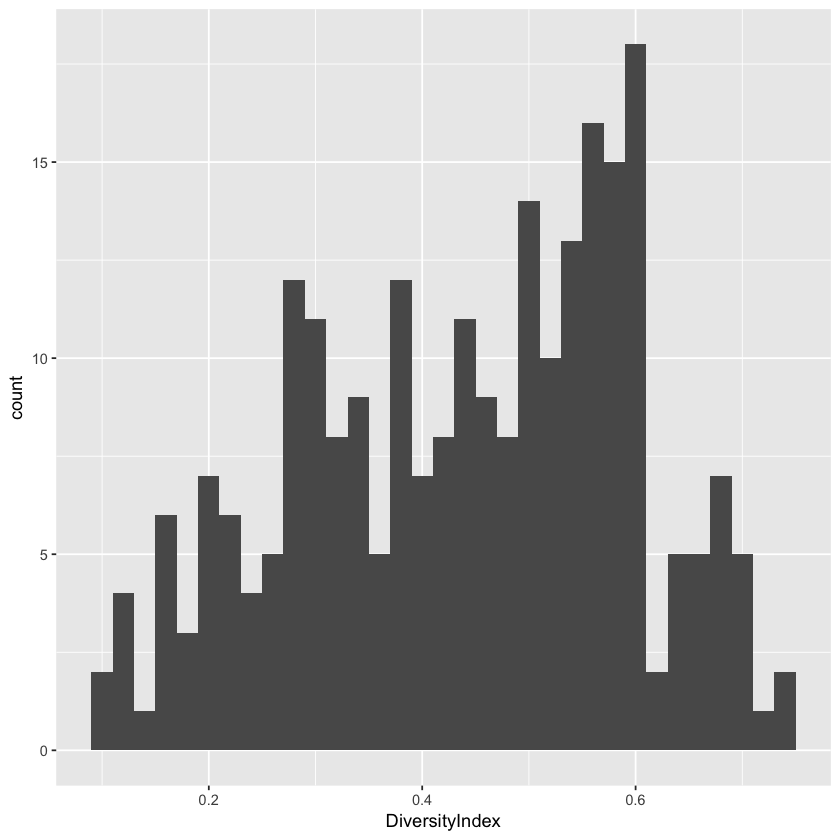

In [9]:
ggplot(diversity, aes(x=DiversityIndex)) +
geom_histogram(binwidth=0.02)

In [10]:
property.values <- df.ma %>%
filter(PERNUM == 1) %>%
group_by(CBSA) %>%
summarize(MedianRent = weighted.median(RENT, HHWT),
          MedianHouseValue = weighted.median(VALUEH, HHWT))

In [11]:
metro.summary.data <- df.ma %>%
group_by(CBSA) %>%
mutate(IsAdult = ifelse(AGE > 18, PERWT, 0)) %>%
mutate(HighSchool = ifelse(EDUCD_orig >= 62, PERWT, 0)) %>%
mutate(College = ifelse(EDUCD_orig >= 100, PERWT, 0)) %>%
mutate(PostGrad = ifelse(EDUCD_orig >= 114, PERWT, 0)) %>%
mutate(IsFemale = ifelse(SEX=='Female', PERWT, 0)) %>%
mutate(BornOutOfState = ifelse(BPL != State, PERWT, 0)) %>%
mutate(IsImmigrant = ifelse(BPL_orig >= 100, PERWT, 0)) %>%
summarize(TotalPeople = sum(PERWT),
          TotalTech = sum(Tech),
          MedianAge = weighted.median(AGE, PERWT),
          PercentHighSchool = sum(HighSchool) / sum(PERWT),
          PercentCollege = sum(College) / sum(PERWT),
          PercentPostGrad = sum(PostGrad) / sum(PERWT),
          MedianIncome = weighted.median(INCTOT, PERWT),
          PercentFemale = sum(IsFemale) / sum(PERWT),
          PercentBornOutOfState = sum(BornOutOfState) / sum(PERWT),
          PercentImmigrant = sum(IsImmigrant) / sum(PERWT)) %>%
mutate(PercentTech = TotalTech / TotalPeople * 100)

CBSA,TotalPeople,TotalTech,MedianAge,PercentHighSchool,PercentCollege,PercentPostGrad,MedianIncome,PercentFemale,PercentBornOutOfState,PercentImmigrant,PercentTech
"El Centro, CA",180355,250,32,0.5003244,0.09918217,0.02923678,10100,0.4888193,0.4132905,0.3461007,0.1386155


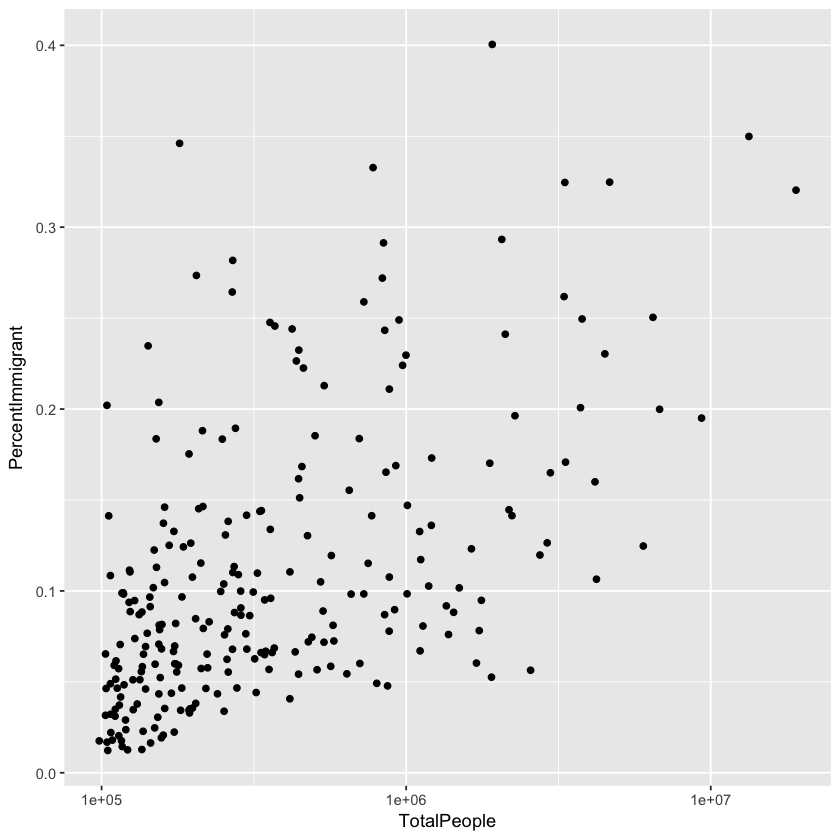

In [12]:
ggplot(metro.summary.data, aes(x=TotalPeople, y=PercentImmigrant)) +
geom_point() +
scale_x_log10()
metro.summary.data %>% filter(TotalPeople < 500000, PercentImmigrant > 0.3)

In [13]:
metro.summary.data %>%
left_join(property.values) %>%
left_join(diversity) %>%
write.csv('metro_summary_data.csv')

Joining, by = "CBSA"
Joining, by = "CBSA"
